#Download lagre file

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/MasterThesis/Colab Model/Data/"
!unzip -q "/content/drive/MyDrive/MasterThesis/Colab Model/Data/Cardiac_General.zip"

'3class (normal, 4CV, 3VT).gdoc'   Cardiac_General.zip	 Cardiac_Original.zip   output.csv


#Setup Libraries

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
import numpy as npfb
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import time
import os
import copy
import cv2
import shutil
from datetime import datetime
import pytz
from torchsummary import summary
from PIL import Image, ImageFile
from torch.utils.data import WeightedRandomSampler
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix
import argparse

# Customized CNN models

In [ ]:
#Data Augmentation
def augment(path,IMG_DIM):

  datagen = ImageDataGenerator(rotation_range=40,width_shift_range=.2,height_shift_range=.2,shear_range=.2,zoom_range=.2,horizontal_flip=True,fill_mode='nearest')
  directories = os.listdir(path)
  files_path = []
  labels = []

  for i in range(len(directories)):
    ls = []
    curPath = path +'/' +directories[i] + '/*'
    ls = glob.glob(curPath)
    temp = []
    for img in ls:
      x = img_to_array(load_img(img,target_size = IMG_DIM))
      x = x.reshape((1,)+x.shape)
      temp.append(x)
    i = 0
    target = 800
    for batch in datagen.flow(temp,batch_size=4,save_to_dir=curPath[:-1],save_format='jpg'):
      i += 1
      if len(ls) + i*4>800:
        break

#Creating Frame
def createFrame(path,IMG_DIM):
  train_imgs = []
  labels = []
  directories = os.listdir(path)
  for i in range(len(directories)):
    ls = []
    temp = []
    curPath = path +'/' +directories[i] + '/*'
    ls = glob.glob(curPath)
    for img in ls:
      x = img_to_array(load_img(img,target_size = IMG_DIM))
      temp.append(x)

    train_imgs  = train_imgs + temp
    label = []
    label = [i]*len(ls)
    labels += label

  df = pd.DataFrame(list(zip(train_imgs,labels)))
  df = df.sample(frac = 1)
  return df

def kFold(df):

  df['kfold'] = -1
  df = df.reset_index(drop=True)
  y = df[1]
  kf = model_selection.StratifiedKFold(n_splits=5)
  for f,(t_,v_) in enumerate(kf.split(X=df,y=y)):
    df.loc[v_,'kfold'] = f

  return df

#Customized CNN models
def DenseNet169(train_imgs,train_labels,class_no,num_epochs=10):
  print("-------------------------------------DenseNet-169--------------------------------------------")
  input_shape_densenet = (224, 224, 3)
  densenet_model1 = keras.applications.DenseNet169(include_top=False,weights="imagenet",input_tensor=None,input_shape=input_shape_densenet,pooling=None)
  densenet_model1.trainable = True
  for layer in densenet_model1.layers:
    layer.trainable = False

  layer = keras.layers.Flatten()(densenet_model1.output)
  layer = keras.layers.Dense(units=512,activation='relu')(layer)
  layer = keras.layers.Dropout(0.2)(layer)
  layer = keras.layers.Dense(units=128,activation='relu')(layer)
  layer = keras.layers.Dense(units=class_no,activation='softmax')(layer)
  model1 = keras.models.Model(densenet_model1.input, outputs=layer)
  model1.compile(optimizer = keras.optimizers.RMSprop(learning_rate=2e-5),loss='categorical_crossentropy',metrics=['acc'])
  history = model1.fit(x=train_imgs,y=train_labels, epochs = num_epochs, batch_size = 32, verbose=0, validation_split=0.2)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy of DenseNet-169')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  print("------------------------------------------------------------------------------------------")
  return model1

def VGG16(train_imgs,train_labels,class_no,num_epochs=10):
  print("-------------------------------------VGG16---------------------------------------------")
  pre_trained_model2 = keras.applications.VGG16(input_shape = (224,224,3), include_top=False,weights="imagenet")
  for layer in pre_trained_model2.layers:
    layer.trainable = False
  x = keras.layers.Flatten()(pre_trained_model2.output)
  x = layers.Dense(1024,activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(64,activation='relu')(x)
  x = layers.Dense(class_no,activation='softmax')(x)
  model2 = Model(pre_trained_model2.input,x)
  model2.compile(optimizer = RMSprop(learning_rate=2e-5),loss='categorical_crossentropy',metrics=['acc'])
  history = model2.fit(x=train_imgs,y=train_labels, epochs = num_epochs, batch_size = 32, verbose=0, validation_split=0.2)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy of Xception')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  print("------------------------------------------------------------------------------------------")
  return model2

def Xception(train_imgs,train_labels,class_no,num_epochs=10):
  print("-------------------------------------XCEPTION---------------------------------------------")
  pre_trained_model3 = keras.applications.Xception(input_shape = (224,224,3), include_top=False,weights="imagenet")
  for layer in pre_trained_model3.layers:
    layer.trainable = False
  x = keras.layers.Flatten()(pre_trained_model3.output)
  x = layers.Dense(102,activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(32,activation='relu')(x)
  x = layers.Dense(class_no,activation='softmax')(x)
  model3 = Model(pre_trained_model3.input,x)
  model3.compile(optimizer = RMSprop(learning_rate=2e-5),loss='categorical_crossentropy',metrics=['acc'])
  history = model3.fit(x=train_imgs,y=train_labels, epochs = num_epochs, batch_size = 32, verbose=0, validation_split=0.2)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy of Xception')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  print("------------------------------------------------------------------------------------------")
  return model3




# Generate Fuzzy Rank-based Score

In [ ]:

#Fuzzy Rank-based Ensemble:
def getScore(model,test_imgs):
  res = model.predict(test_imgs)
  return res

def generateRank1(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1 - np.exp(-((scores[i]-1)**2)/2.0)
  return rank

def generateRank2(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1 - np.tanh(((scores[i]-1)**2)/2)
  return rank

def generateRank3(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1/(1+(np.exp(-scores[i])))
  return rank

def doFusion(res1,res2,res3,label,class_no):
  cnt = 0
  id = []
  print(class_no)
  for i in range(len(res1)):
      rank1 = generateRank1(res1[i],class_no)*generateRank2(res1[i],class_no)
      rank2 = generateRank1(res2[i],class_no)*generateRank2(res2[i],class_no)
      rank3 = generateRank1(res3[i],class_no)*generateRank2(res3[i],class_no)
      rankSum = rank1 + rank2 + rank3
      rankSum = np.array(rankSum)
      scoreSum = 1 - (res1[i] + res2[i] + res3[i])/3
      scoreSum = np.array(scoreSum)

      fusedScore = (rankSum.T)*scoreSum
      cls = np.argmin(rankSum)
      if cls<class_no and label[i][cls]== 1:
          cnt += 1
      id.append(cls)
  print("doFusion Score")
  print(cnt/len(res1))
  return id



# Fuzzy Rank-based Ensemble

----------------------------------------------------FOLD NO 1-------------------------------------------------------
-------------------------------------DenseNet-169--------------------------------------------


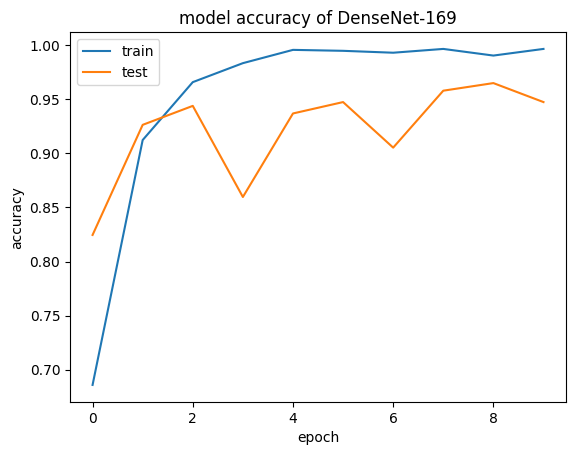

------------------------------------------------------------------------------------------
-------------------------------------VGG16---------------------------------------------
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


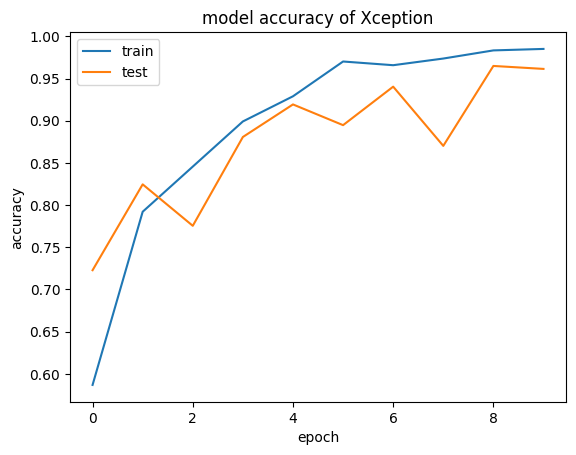

------------------------------------------------------------------------------------------
-------------------------------------XCEPTION---------------------------------------------
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


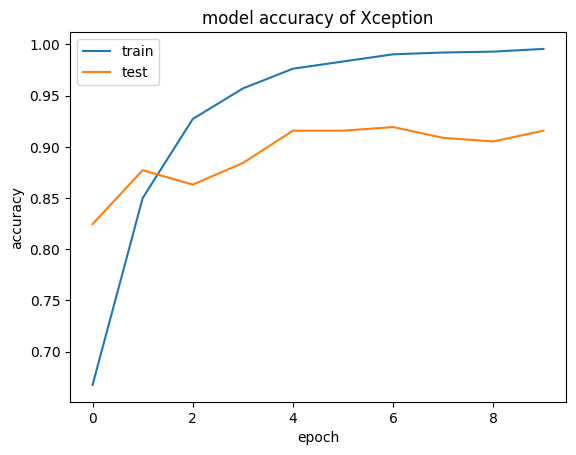

Streaming output truncated to the last 5000 lines.
[[0.21161124]
 [0.00069316]
 [0.21042153]]
===3
[[0.6348262 ]
 [0.23160202]
 [0.39656725]]
ranksum====
score sum
[0.99826044 0.38041908 0.6213205 ]
scoresum====
fused score
[[0.63372188 0.08810583 0.24639536]]
fused score=====
get rank1/exp
3
[[3.93468843e-01]
 [3.93468338e-01]
 [3.28448380e-12]]
score
[8.2043488e-07 1.6530464e-06 9.9999744e-01]
score----1
get rank2/tanh
3
[[0.53788349]
 [0.53788414]
 [1.        ]]
score
[8.2043488e-07 1.6530464e-06 9.9999744e-01]
score----2
get rank1/exp
3
[[0.38162398]
 [0.38388145]
 [0.00062431]]
score
[0.01953219 0.01580908 0.96465874]
score----1
get rank2/tanh
3
[[0.55322912]
 [0.55030661]
 [0.9993755 ]]
score
[0.01953219 0.01580908 0.96465874]
score----2
get rank1/exp
3
[[3.92866812e-01]
 [3.92332272e-01]
 [4.11320691e-06]]
score
[9.9340163e-04 1.8747105e-03 9.9713182e-01]
score----1
get rank2/tanh
3
[[0.53866407]
 [0.5393571 ]
 [0.99999589]]
score
[9.9340163e-04 1.8747105e-03 9.9713182e-01]
scor

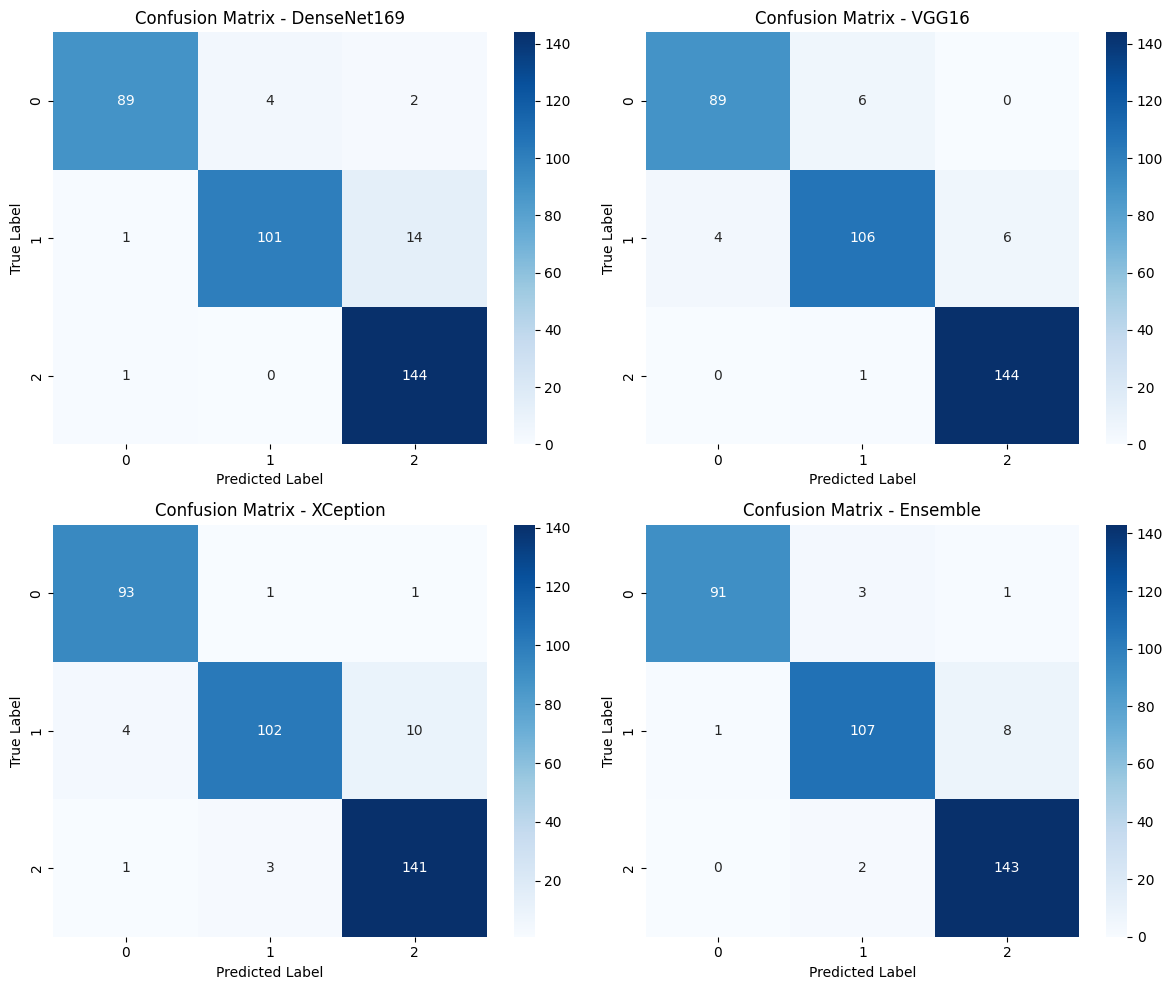

--------------------------------------------------END OF FOLD NO 1--------------------------------------------------------


In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_directory', type=str, default = '.', help='Directory where the image data is stored')
parser.add_argument('--epochs', type=int, default = 10, help='Number of Epochs of training')

args = parser.parse_args(['--data_directory', '/content/Cardiac_General', '--epochs', '10'])

path1 = args.data_directory
num_epochs = args.epochs

IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT,3)

df = createFrame(path1,IMG_DIM)
df = kFold(df)

target_names = os.listdir(path1)
num_classes = len(target_names)

for i in range(1,5):
  print(f"----------------------------------------------------FOLD NO {i}-------------------------------------------------------")
  dfTrain = df[df['kfold']!=i]
  dfTest = df[(df['kfold']==i)]
  train_imgs = list(dfTrain[0])
  train_imgs = np.array(train_imgs)
  train_imgs = train_imgs/255
  train_labels = np.array(dfTrain[1])
  encoder = LabelEncoder()
  encoder.fit(train_labels)
  train_labels = encoder.transform(train_labels)
  train_labels = to_categorical(train_labels)

  test_imgs = list(dfTest[0])
  test_imgs = np.array(test_imgs)
  test_imgs = test_imgs/255
  test_labels = np.array(dfTest[1])
  encoder = LabelEncoder()
  encoder.fit(test_labels)
  test_labels = encoder.transform(test_labels)
  test_labels = to_categorical(test_labels)

  model1 = DenseNet169(train_imgs,train_labels,class_no=num_classes,num_epochs=10)
  model2 = VGG16(train_imgs,train_labels,class_no=num_classes,num_epochs=10)
  model3 = Xception(train_imgs,train_labels,class_no=num_classes,num_epochs=10)

  print("BASE LEARNERS ACCURACY-----------1.DenseNet169 2.VGG16 3.Xception")
  model1.evaluate(test_imgs, test_labels, batch_size=32)
  model2.evaluate(test_imgs, test_labels, batch_size=32)
  model3.evaluate(test_imgs, test_labels, batch_size=32)

  res1 = model1.predict(test_imgs)
  res2 = model2.predict(test_imgs)
  res3 = model3.predict(test_imgs)
  predictedClass = doFusion(res1,res2,res3,test_labels,class_no=num_classes)

  prob1 = np.max(res1,axis=-1)
  prob2 = np.max(res2,axis=-1)
  prob3 = np.max(res3,axis=-1)

  leb1 = np.argmax(res1,axis=-1)
  leb2 = np.argmax(res2,axis=-1)
  leb3 = np.argmax(res3,axis=-1)
  actual = np.argmax(test_labels,axis=-1)

  cm_model1 = confusion_matrix(actual, leb1)
  cm_model2 = confusion_matrix(actual, leb2)
  cm_model3 = confusion_matrix(actual, leb3)
  cm_ensemble = confusion_matrix(actual, predictedClass)

  print('DenseNet169 base learner')
  print(classification_report(actual, leb1,target_names = target_names,digits=4))
  print("P cho densenet", prob1)
  plt.figure(figsize=(18, 10))
  plt.subplot(2,3,1)
  sns.heatmap(cm_model1, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix - DenseNet169')
  print('VGG16 base learner')
  print(classification_report(actual, leb2,target_names = target_names,digits=4))
  print("P cho vgg16", prob2)
  plt.subplot(2, 3, 2)
  sns.heatmap(cm_model2, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix - VGG16')
  print('XCeption base learner')
  print(classification_report(actual, leb3,target_names = target_names,digits=4))
  print("P cho xception", prob3)
  plt.subplot(2, 3, 4)
  sns.heatmap(cm_model3, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix - XCeption')

  print('Ensembled')
  print(classification_report(actual, predictedClass,target_names = target_names,digits=4))
  plt.subplot(2, 3, 5)
  sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix - Ensemble')
  plt.tight_layout()
  plt.show()

  print(f"--------------------------------------------------END OF FOLD NO {i}--------------------------------------------------------")


